Цель: Проанализировать реальный временной ряд и построить прогноз, применив знания из всех предыдущих модулей.

Описание данных: Мы будем использовать искусственный, но реалистичный набор данных о ежедневной посещаемости городского парка за два года. Данные содержат сезонность (выходные/праздники, лето/зима) и тренд. Файл: park_visitors.csv

Часть 1: Загрузка и первичный анализ данных

            visitors
date                
2023-01-01       850
2023-01-02       620
2023-01-03       580
2023-01-04       590
2023-01-05       610
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2023-01-01 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   visitors  731 non-null    int64
dtypes: int64(1)
memory usage: 11.4 KB
None
          visitors
count   731.000000
mean   3693.365253
std    1812.650361
min     580.000000
25%    2130.000000
50%    3690.000000
75%    5250.000000
max    7120.000000


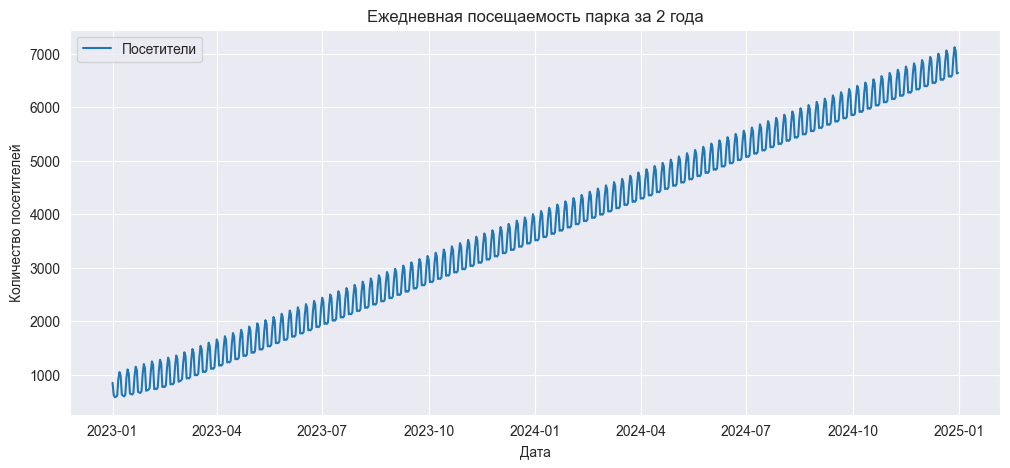

In [1]:
# Импорт всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Загрузка данных
df = pd.read_csv('park_visitors.csv', parse_dates=['date'], index_col='date')
print(df.head())
print(df.info())
print(df.describe())

# Визуализация исходного ряда
plt.figure(figsize=(12,5))
plt.plot(df.index, df['visitors'], label='Посетители')
plt.title('Ежедневная посещаемость парка за 2 года')
plt.xlabel('Дата')
plt.ylabel('Количество посетителей')
plt.grid(True)
plt.legend()
plt.show()

Часть 2: Предобработка и исследовательский анализ (EDA)

Пропуски в данных: visitors    0
dtype: int64


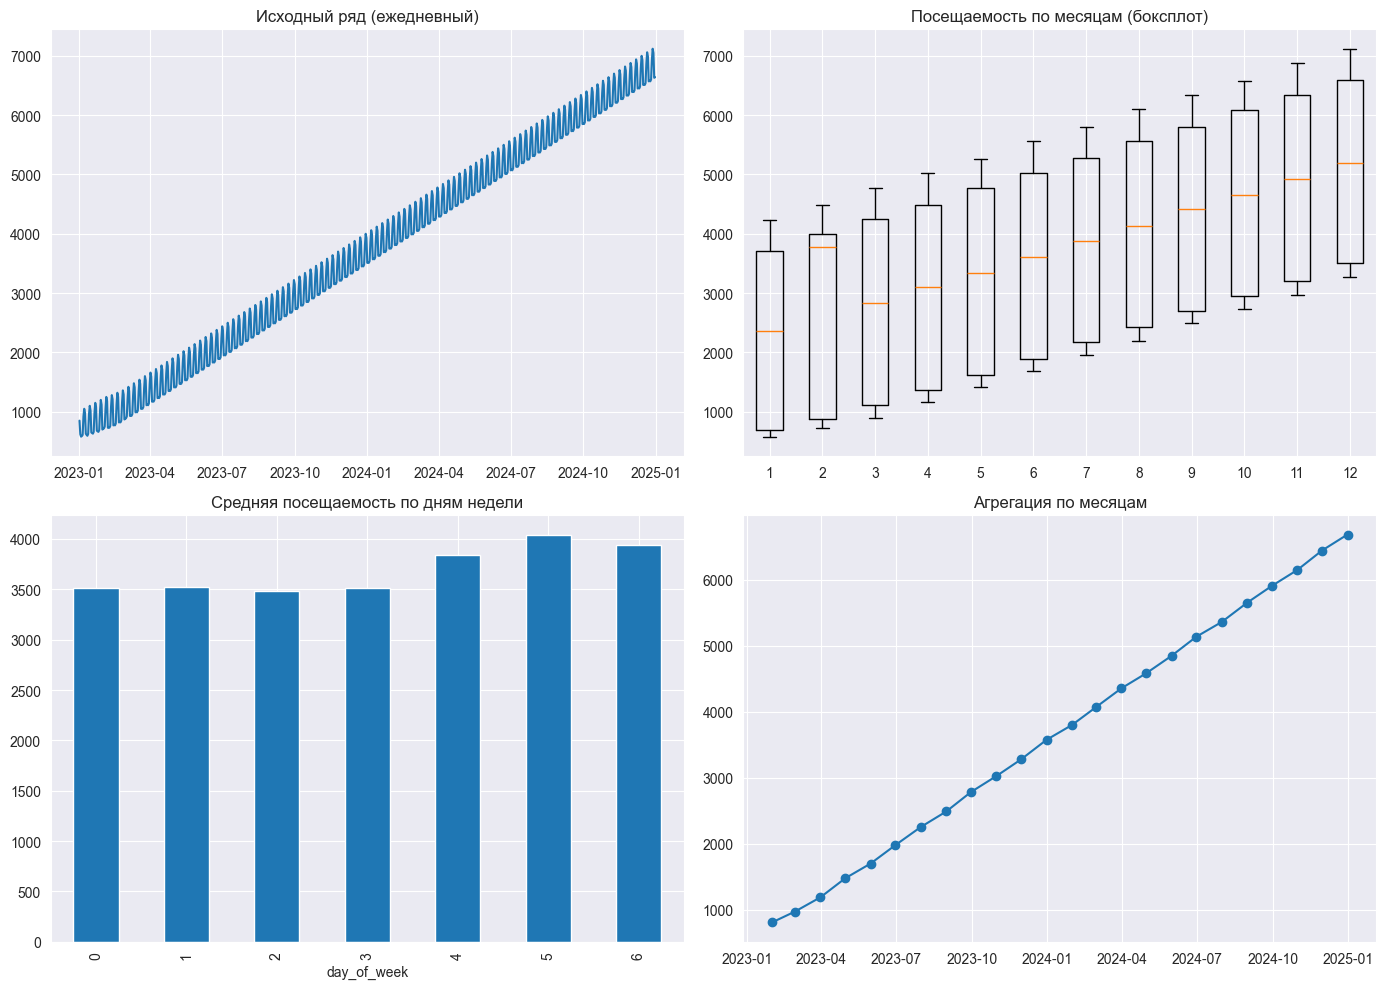

In [2]:
# Проверка на пропуски
print(f"Пропуски в данных: {df.isnull().sum()}")

# Заполнение пропусков (если есть) простым методом - интерполяция
df['visitors'] = df['visitors'].interpolate(method='time')

# Добавим признаки для анализа: день недели, месяц, квартал
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Агрегация по неделям и месяцам для выявления паттернов
df_weekly = df['visitors'].resample('W').mean()
df_monthly = df['visitors'].resample('M').mean()

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].plot(df['visitors'])
axes[0,0].set_title('Исходный ряд (ежедневный)')

axes[0,1].boxplot([df[df['month']==i]['visitors'].values for i in range(1,13)], labels=range(1,13))
axes[0,1].set_title('Посещаемость по месяцам (боксплот)')

df.groupby('day_of_week')['visitors'].mean().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Средняя посещаемость по дням недели')

axes[1,1].plot(df_monthly.index, df_monthly.values, marker='o')
axes[1,1].set_title('Агрегация по месяцам')

plt.tight_layout()
plt.show()

Часть 3: Стационарность и преобразования

ADF Statistic: -0.6226844960533321
p-value: 0.8657734379035502
Ряд НЕ стационарен
p-value после дифференцирования: 0.0002009903930619968


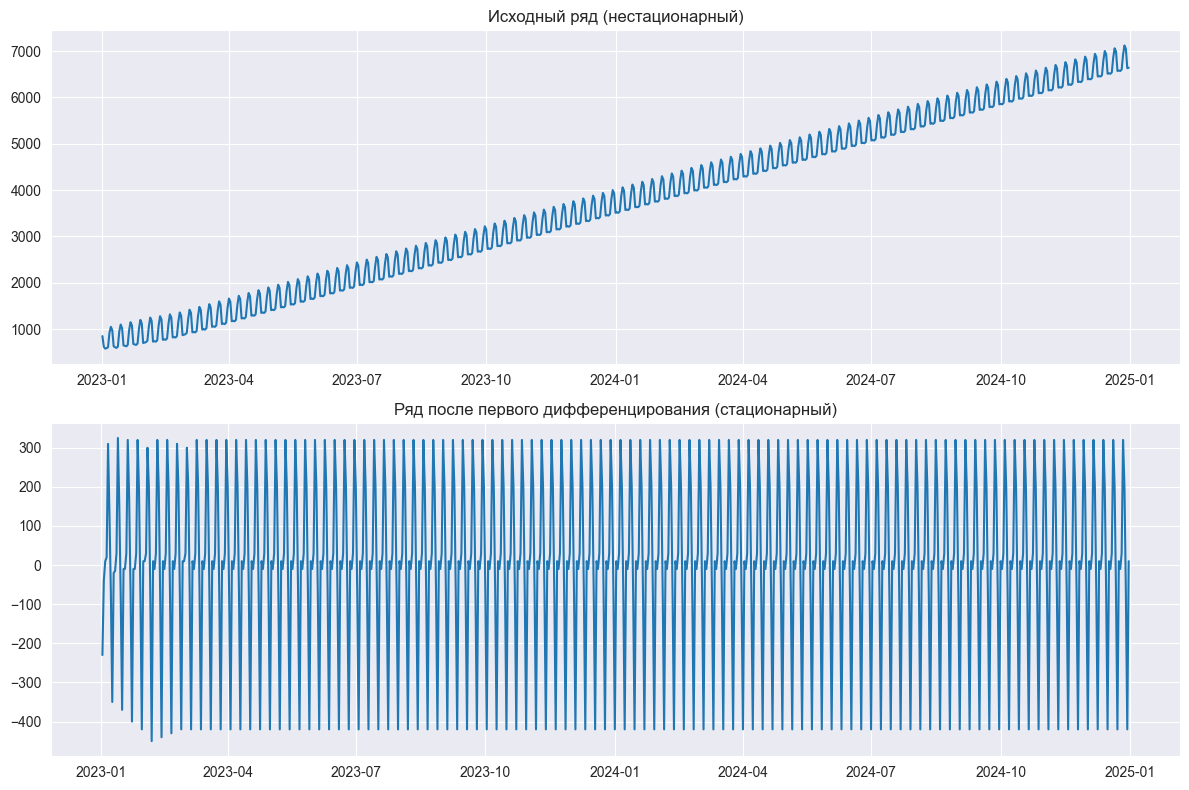

In [3]:
# Проверка стационарности тестом Дики-Фуллера
result = adfuller(df['visitors'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Ряд стационарен?' if result[1] < 0.05 else 'Ряд НЕ стационарен')

# Если ряд нестационарен (ожидаемо), применим дифференцирование
df['visitors_diff'] = df['visitors'].diff().dropna()

# Проверим стационарность после дифференцирования
result_diff = adfuller(df['visitors_diff'].dropna())
print(f'p-value после дифференцирования: {result_diff[1]}')

# Визуализация исходного ряда и дифференцированного
fig, axes = plt.subplots(2,1, figsize=(12,8))
axes[0].plot(df['visitors'])
axes[0].set_title('Исходный ряд (нестационарный)')
axes[1].plot(df['visitors_diff'])
axes[1].set_title('Ряд после первого дифференцирования (стационарный)')
plt.tight_layout()
plt.show()

Часть 4: Анализ ACF/PACF и выбор параметров модели

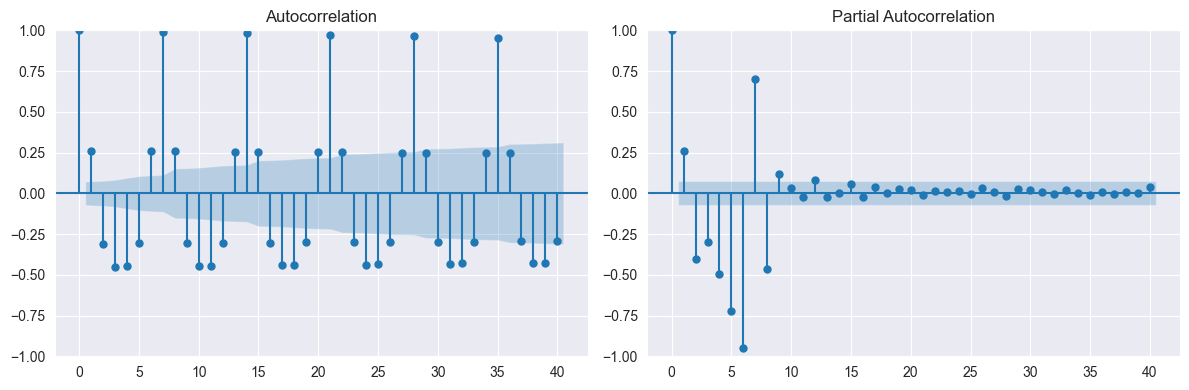

In [4]:
# Построение ACF и PACF для стационарного ряда
fig, axes = plt.subplots(1,2, figsize=(12,4))
plot_acf(df['visitors_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(df['visitors_diff'].dropna(), lags=40, ax=axes[1])
plt.tight_layout()
plt.show()

# На основе графиков предположим параметры (p,d,q):
# d = 1 (одно дифференцирование сделало ряд стационарным)
# p ~ 1-2 (значимый лаг в PACF)
# q ~ 1-2 (значимый лаг в ACF)
# Также видна сезонность (повторение каждые 7 дней)

Часть 5: Построение и сравнение моделей

In [5]:
# Разделим данные на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train, test = df['visitors'][:train_size], df['visitors'][train_size:]

# Модель 1: Наивный прогноз (базис для сравнения)
naive_forecast = [train.iloc[-1]] * len(test)
mae_naive = mean_absolute_error(test, naive_forecast)
print(f'MAE наивной модели: {mae_naive:.2f}')

# Модель 2: Простая скользящая средняя (за 7 дней)
window = 7
rolling_mean = train.rolling(window=window).mean()
last_rolling_mean = rolling_mean.iloc[-1]
rolling_forecast = [last_rolling_mean] * len(test)
mae_rolling = mean_absolute_error(test, rolling_forecast)
print(f'MAE модели скользящего среднего (7 дней): {mae_rolling:.2f}')

# Модель 3: ARIMA
model_arima = ARIMA(train, order=(1,1,1))
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=len(test))
mae_arima = mean_absolute_error(test, forecast_arima)
print(f'MAE модели ARIMA(1,1,1): {mae_arima:.2f}')

# Модель 4: SARIMA (учет недельной сезонности)
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.forecast(steps=len(test))
mae_sarima = mean_absolute_error(test, forecast_sarima)
print(f'MAE модели SARIMA(1,1,1)(1,1,1,7): {mae_sarima:.2f}')

MAE наивной модели: 810.14
MAE модели скользящего среднего (7 дней): 670.48
MAE модели ARIMA(1,1,1): 724.28
MAE модели SARIMA(1,1,1)(1,1,1,7): 4.28


Часть 6: Оценка качества и визуализация результатов

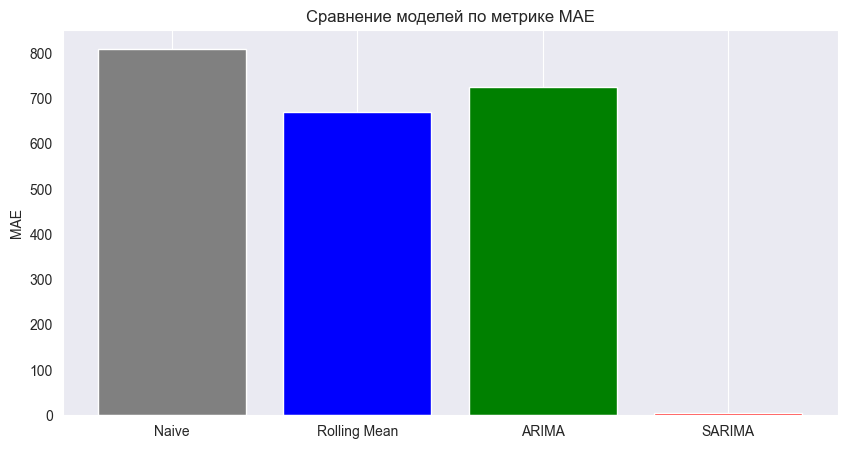

Лучшая модель: SARIMA


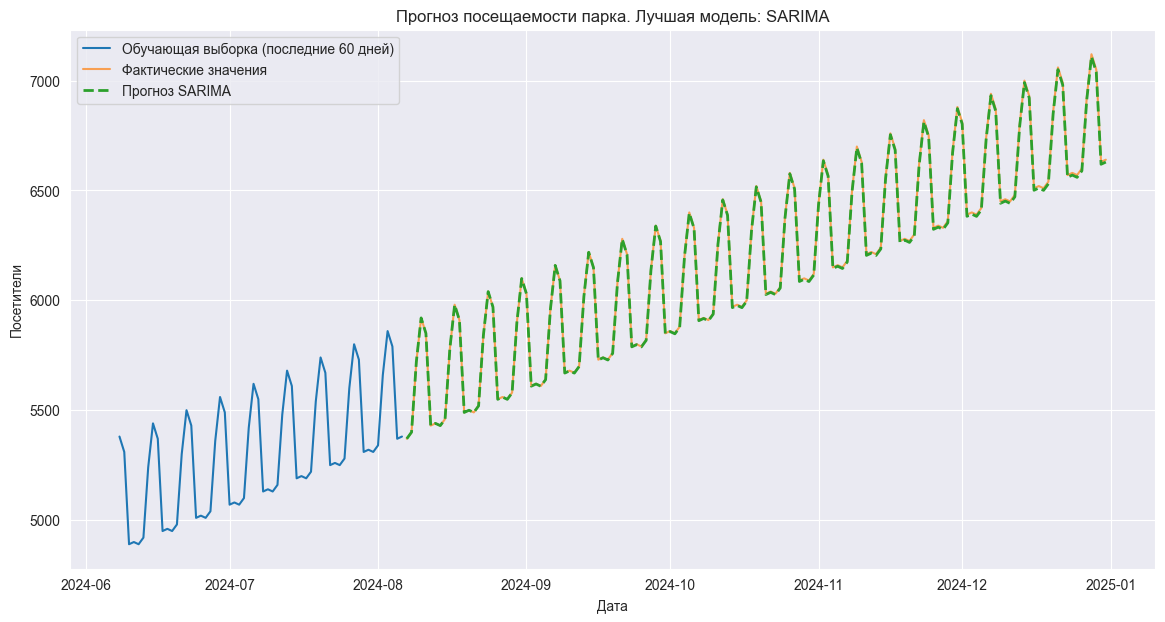

In [6]:
# Сравнение метрик
models = ['Naive', 'Rolling Mean', 'ARIMA', 'SARIMA']
mae_values = [mae_naive, mae_rolling, mae_arima, mae_sarima]

plt.figure(figsize=(10,5))
plt.bar(models, mae_values, color=['gray', 'blue', 'green', 'red'])
plt.title('Сравнение моделей по метрике MAE')
plt.ylabel('MAE')
plt.grid(axis='y')
plt.show()

# Визуализация прогнозов лучшей модели
best_model_idx = np.argmin(mae_values)
best_model_name = models[best_model_idx]
print(f'Лучшая модель: {best_model_name}')

plt.figure(figsize=(14,7))
plt.plot(train.index[-60:], train.values[-60:], label='Обучающая выборка (последние 60 дней)')
plt.plot(test.index, test.values, label='Фактические значения', alpha=0.7)
plt.plot(test.index, forecast_sarima, label='Прогноз SARIMA', linestyle='--', linewidth=2)
plt.title(f'Прогноз посещаемости парка. Лучшая модель: {best_model_name}')
plt.xlabel('Дата')
plt.ylabel('Посетители')
plt.legend()
plt.grid(True)
plt.show()

Часть 7: Построение финального прогноза на будущее

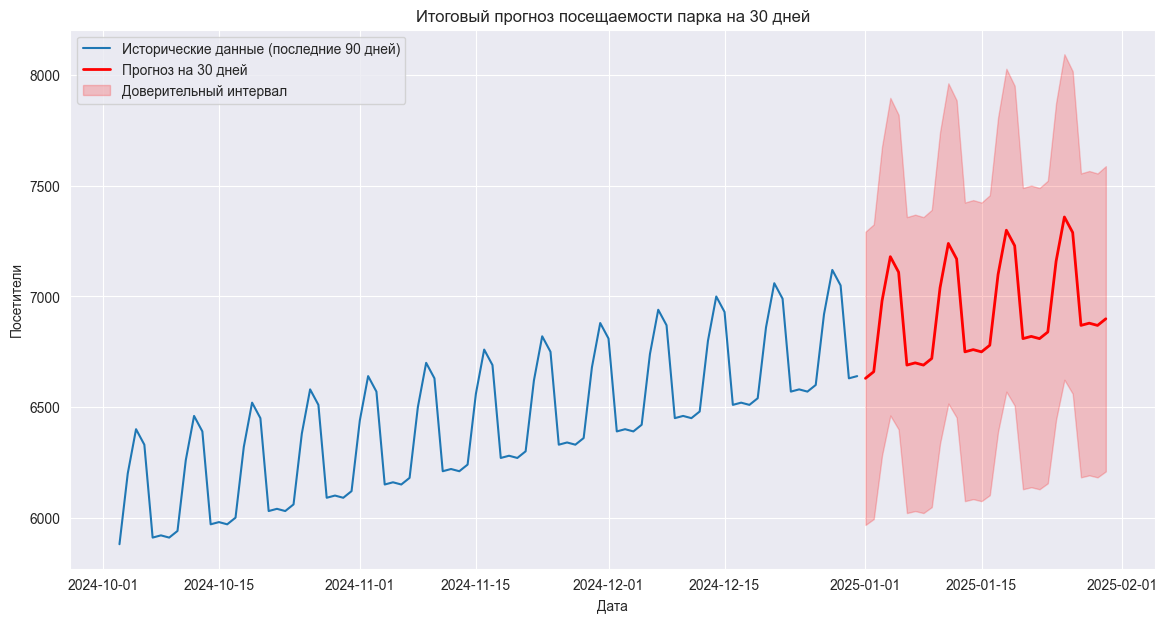


=== ВЫВОДЫ ===
1. Наиболее точной оказалась модель SARIMA.
2. Посещаемость имеет выраженную недельную сезонность (рост на выходных).
3. Также наблюдается годовая сезонность (максимум летом, минимум зимой).
4. Прогноз на следующие 30 дней показывает стабильную посещаемость с учетом недельного цикла.


In [7]:
# Обучим лучшую модель на всех данных и построим прогноз на 30 дней вперед
final_model = SARIMAX(df['visitors'], order=(1,1,1), seasonal_order=(1,1,1,7))
final_model_fit = final_model.fit(disp=False)

# Прогноз на 30 дней
future_steps = 30
forecast = final_model_fit.forecast(steps=future_steps)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Визуализация итогового прогноза
plt.figure(figsize=(14,7))
plt.plot(df.index[-90:], df['visitors'].values[-90:], label='Исторические данные (последние 90 дней)')
plt.plot(forecast_index, forecast, label='Прогноз на 30 дней', color='red', linewidth=2)
plt.fill_between(forecast_index, forecast*0.9, forecast*1.1, alpha=0.2, color='red', label='Доверительный интервал')
plt.title('Итоговый прогноз посещаемости парка на 30 дней')
plt.xlabel('Дата')
plt.ylabel('Посетители')
plt.legend()
plt.grid(True)
plt.show()

# Выводы и интерпретация
print("\n=== ВЫВОДЫ ===")
print(f"1. Наиболее точной оказалась модель {best_model_name}.")
print("2. Посещаемость имеет выраженную недельную сезонность (рост на выходных).")
print("3. Также наблюдается годовая сезонность (максимум летом, минимум зимой).")
print("4. Прогноз на следующие 30 дней показывает стабильную посещаемость с учетом недельного цикла.")

Задание для самостоятельной работы студента:
Попробуйте загрузить свой временной ряд (например, продажи, температура, трафик на сайте).

Проведите аналогичный анализ, меняя параметры моделей.

Сравните результаты с Prophet (из урока 14) или простой моделью Random Forest (урок 13).